In [2]:
import requests
import json
import datetime
import pandas as pd
import re
import os
import random
import urllib3
import time
import matplotlib
import nltk

from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from datetime import datetime
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

path = '../data/TW/'

# 0. read in data & some preprocess

## read in whole dataset

In [12]:
df = pd.read_csv(path + "TW_news.csv")
df = df.drop(columns = ['index'])
df.sample(3)

,title,keyword_dpp,keyword_han,keyword_kmt,keyword_tsai,content,keyword_election,date,source,sub_source
4568,胡志強伉儷挺韓國瑜 邵曉鈴請藍綠別再對立,False,True,True,False,前台中市長胡志強（右2）與夫人邵曉鈴（左2）出席國民黨總統候選人韓國瑜大台中造勢晚會。（記者...,False,2019-12-29 00:00:00+00:00,ltn,NaN
8674,反送中蔡政府竟6天3變 韓國瑜親說重話了！,True,True,True,True,香港反送中的導火線「殺女嫌犯陳同佳」有意來台投案，卻遭蔡政府統一口徑拒絕。上至總統蔡英文、行...,False,2019-10-23 08:57:30+00:00,cti,NaN
10452,黃瀞瑩違行政中立？羅智強五字神解析 民進黨中槍,True,False,False,False,北市議員秦慧珠29日在議會質疑，北市府副發言人「學姐」黃瀞瑩公器黨用、濫用市府資源，上下班...,False,2019-10-31 16:01:02+00:00,cti,NaN


In [13]:
## create onehot coded keywords recors
df['keyword_tsai'] = False
df.loc[df.content.str.contains('蔡英文'), 'keyword_tsai'] = True

df['keyword_dpp'] = False
df.loc[df.content.str.contains('民進黨'), 'keyword_dpp'] = True

df['keyword_han'] = False
df.loc[df.content.str.contains('韓國瑜'), 'keyword_han'] = True

df['keyword_kmt'] = False
df.loc[df.content.str.contains('國民黨'), 'keyword_kmt'] = True

df['keyword_election'] = False
df.loc[df.content.str.contains('|'.join(['總統大選', '選舉', "大選"])), 'keyword_election'] = True

print(df.shape)
df = df[df[['keyword_tsai', 'keyword_han', 'keyword_kmt', 'keyword_dpp', 'keyword_election']].any(axis=1)]
print(df.shape)

(11618, 10)
(11618, 10)


In [14]:
df["date"] = pd.to_datetime(df.date)

In [15]:
print(len(df[df.source=='cti']), len(df[df.source=='ltn']), len(df[df.source=='central']))

4269 6387 962


In [17]:
df[df.source=='central'].sub_source.value_counts()

cna         702
pts         144
reporter    116
Name: sub_source, dtype: int64

## get undersample dataset

In [55]:
# Count the number of observations for each source
source_counts = df['source'].value_counts()

# Find the minimum count among the sources
min_count = source_counts.min()
print(min_count)

# Subset the data to include only observations with the minimum count for each source
subset_df = df.groupby('source').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

962


In [56]:
print(subset_df.shape)

(2886, 10)


# 1. analysis

## define graph functions

In [57]:

def show_keyword_weekly_count(data):
#     convert 'date' column to datetime type and set as index

    data = data.copy()
    data['date'] = pd.to_datetime(data['date'])
    
    try:
        data.set_index('date', inplace=True)
    except: pass
#     print(data)
    
    
    # resample data by day and count the number of occurrences
    weekly_counts = pd.DataFrame(data.resample('W').sum())
    g = sns.lineplot(data=weekly_counts)
#     , labels=['Trump', "Republican", "Biden", "Democratic", "Election"]
    plt.axvline(x=pd.to_datetime('2020-01-11'), color='r', linestyle='--', label='2020 Presidential Election')

    plt.legend(loc='upper left')
    plt.show(g)


/var/folders/_7/rk2bxwhd5wv3rvl66tld1lvr0000gn/T/ipykernel_16700/79192288.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_counts = pd.DataFrame(data.resample('W').sum())


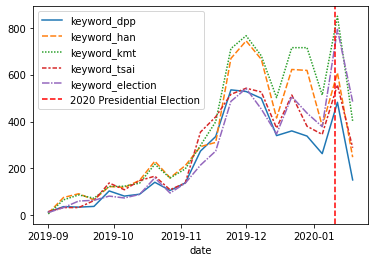

/var/folders/_7/rk2bxwhd5wv3rvl66tld1lvr0000gn/T/ipykernel_16700/79192288.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_counts = pd.DataFrame(data.resample('W').sum())


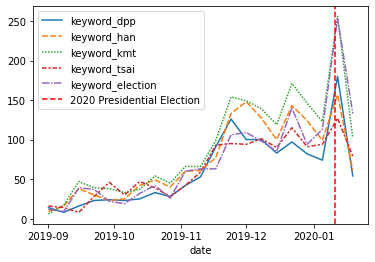

In [58]:
show_keyword_weekly_count(df)
show_keyword_weekly_count(subset_df)

In [59]:
type(df.date[0])

pandas._libs.tslibs.timestamps.Timestamp

In [60]:
def show_source_weekly_count(data):
    
    data = data.copy()
    
    try:
        data.set_index('date', inplace=True)
    except: pass

    # 获取“cnn”来源的数据，并按日期计数
    cti_data = data[data['source'] == 'cti'].resample('W').count()

    # 获取“fox news”来源的数据，并按日期计数
    ltn_data = data[data['source'] == 'ltn'].resample('W').count()

    # 获取“pbs”来源的数据，并按日期计数
    neu_data = data[data['source'] == 'central'].resample('W').count()

    # 绘制三个来源的折线图
    plt.plot(cti_data.index, cti_data['source'], label='CTI News')
    plt.plot(ltn_data.index, ltn_data['source'], label='LTN News')
    plt.plot(neu_data.index, neu_data['source'], label='neutral')
    plt.axvline(x=pd.to_datetime('2020-01-11'), color='r', linestyle='--', label='2020 Presidential Election')

    # 添加标题和轴标签
#     plt.title('Weekly Frequency by Source')
    plt.xlabel('Date')
    plt.ylabel('Frequency')

    # 显示图例
    plt.legend()

    # 显示图形
    plt.show()

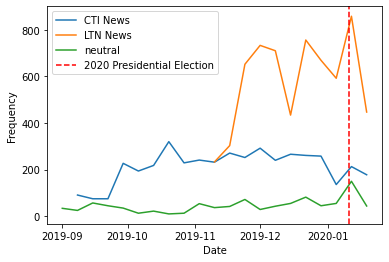

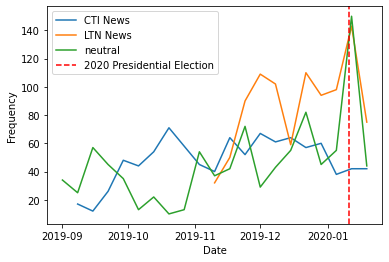

In [61]:
show_source_weekly_count(df)
show_source_weekly_count(subset_df)

In [63]:
def show_keyword_source_barplot(df):
    #show the relation between source and keyword

    data = pd.DataFrame(df.groupby('source')[['keyword_tsai', 'keyword_dpp' , 'keyword_han', 'keyword_kmt', 'keyword_election']].sum())
    data = data.reset_index()

    # Melt the DataFrame to long format
    data_melt = pd.melt(data, id_vars='source', var_name='keyword')
#     print(data_melt)

    # Group the data by source and keyword, and calculate the count
    data_grouped = data_melt.groupby(['source', 'keyword'])['value'].sum().reset_index()

#     print(data_grouped)
    
    sns.set_style("white")
    ax = sns.histplot(
        data_grouped,
        x='keyword',
        # Use the value variable here to turn histogram counts into weighted
        # values.
        weights='value',
        hue='source',
        multiple='stack',
        # Add white borders to the bars.
        edgecolor='white',
        # Shrink the bars a bit so they don't touch.
        shrink=0.8
    )
    ax.set(xlabel='Keywords',
           ylabel='Total Articles',
           xticklabels=["DPP", "Election",  "Han", "KMT", 'Tsai'])
    for i in ax.containers:
        ax.bar_label(i, label_type='center')

    # Remove 'Count' ylabel.
    ax.set_ylabel(None)
    plt.legend(loc='upper left',labels = ['CNA&Reporter', 'CTI', 'LTN'])
    plt.show()
    

/var/folders/_7/rk2bxwhd5wv3rvl66tld1lvr0000gn/T/ipykernel_16700/3466366594.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xlabel='Keywords',


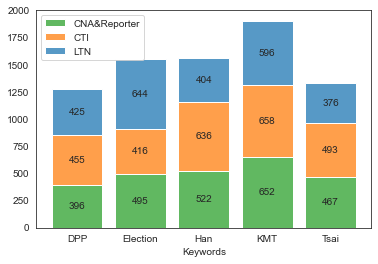

In [64]:
show_keyword_source_barplot(subset_df)

/var/folders/_7/rk2bxwhd5wv3rvl66tld1lvr0000gn/T/ipykernel_16700/3466366594.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xlabel='Keywords',


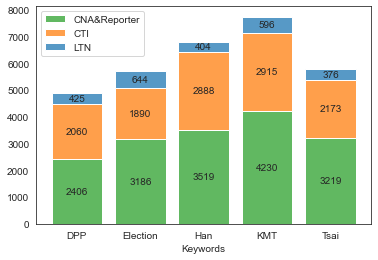

In [65]:
show_keyword_source_barplot(df)